### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2016 ###

# Using Optimization for Task Scheduling #

#### Haojun Zhang (hzhang395@wisc.edu) and Keyi Cui (kcui3@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Models](#2.-Mathematical-models)
  1. [Scheduling Tasks with Time Conflicts](#2.A.-Scheduling-Tasks-with-Time-Conflicts)
  1. [Minimizing Resources or Completion Time](#2.B.-Minimizing-Resources-or-Completion-Time)
  1. [Handling Task Dependency with Limited Resources](#2.C.-Handling-Task-Dependency-with-Limited-Resources)
  1. [TSP with Time Constraint](#2.D.-TSP-with-Time-Constraint) 
1. [Solutions](#3.-Solutions)
  1. [Implementation for 2.A](#3.A.-Implementation-for-2.A)
  1. [Implementation for 2.B](#3.B.-Implementation-for-2.B)
  1. [Implementation for 2.C](#3.C.-Implementation-for-2.C)
  1. [Implementation for 2.D](#3.D.-Implementation-for-2.D)
1. [Results and Discussion](#4.-Results-and-Discussion)
  1. [Data Generator](#4.A.-Data-Generator)
  1. [Demo of Models in 2.A and 2.B](#4.B.-Demo-of-Models-in-2.A-and-2.B)
  1. [Results and Discussion for Model in 2.C](#4.C.-Results-and-Discussion-for-Model-in-2.C)
  1. [Results and Discussion for Model in 2.D](#4.D.-Results-and-Discussion-for-Model-in-2.D)
1. [Conclusion](#5.-Conclusion)
1. [Appendix](#Appendix)

## 1. Introduction ##

In our project, we use optimization to solve a few task scheduling problems. 

Task scheduling is commonly seen in different indutry and science areas. Here we give three examples:

1. Each semester University of Wisconsin-Madison needs to schedule courses to class rooms. Each course has its start and end time, and two courses have to be scheduled to different rooms if their time intervals conflict. Since maintance of a room incurs some cost, they wish to minimize the total number of rooms needed for all courses.

2. A team of scientists plan to do a set of experiments, whose success will be a breakthrough in their research area. There are dependencies among those experiments. Based on their experience, they know roughly how long each experiment will take. Unfortuately, each scientist can only focus on one experiment at any time. They wish to finish all experiments as early as possible because their opponents are currently slightly ahead them in the same experiments.

3. A school bus needs to pick up several students in the morning. For each student, the bus needs to arrive before his/her parents leave for work. Meanwhile, the school is short in budget and wish to find a route with mimimum total distance.   

The above examples are task scheduling problems with following general settings:

1. We wish to schedule $n$ tasks on $m$ processors.
2. Each task may have start time $s_i$, end time $t_i$, workload $w_i$, and bonus (or cost) $b_i$ when completed, and more. There may be dependency among tasks. 
3. Sometimes we are given too many tasks and wish to pick a subset with maximum bonus. In some other cases, we wish to complete all tasks using minimum resources (number of processors), or complete them as soon as possible. 

The difficulty to model such problems depends on the given constraints and objective. Our project will cover both easy and hard scenarios.

The rest of this report is organized as following: we will first present several problems and their mathematical models, then implement them in Julia and JuMP. After that, we will show and discuss some results on synthetically generated datasets. At the end we will summarize our project and propose a few ideas for futhure study. We also include several extra models in the appendix.

## 2. Mathematical models ##

**General Problem Setting:**

We are given $n$ tasks and $m$ processors. Task $i$ may have one or more following property: (1) start time (release time) $s_i$; (2) end time (deadline) $t_i$; (3) workload (processing time) $w_i$; (4) bonus $b_i$, etc. There might be dependecies between tasks. The objective can be one of:

1. maximize total bonus of completed tasks;
2. minimize number of used processors;
3. complete all tasks as early as possible.

For the problems modelled in this report, for task $i$, either $w_i=t_i-s_i$, or no constraints of $s_i$ and $t_i$. Some of the extra models (see the link in Appendix) also cover the scenario that $w_i\leq t_i-s_i$ (That is, we have some flexibility in the scheduled start time of a task). 

The remaining section is organized as follows: we first model two problems with time conflicts between tasks, then study how to minimize resources (number of processors) or completion time. After that, we present the variants of two problems seen in class: the house building example with limited sources, and TSP with time constraint.  

### 2.A. Scheduling Tasks with Time Conflicts
In many situations, tasks to be scheduled have time conflicts with each other. For example, exam time may overlap with a basketball game that we really wish to watch, two classes are scheduled to the same timeslots then they need to have different rooms. 

**Problem Setting:** Given $n$ tasks and $m$ processors. For task $i$, let $s_i$, $t_i$ and $b_i$ be the start time, the end time, and the bonus if completed. 

1. Suppose $m=1$, then which subset of tasks should we complete to get maximum total bonus?
2. If we wish to complete all tasks, what is the smallest $m$ needed?

The main constraint in such scenarios is to guarantee that there is no time conflicts between tasks scheduled on the same processor. Let $S_i$ be the set of tasks conflicting with task $i$. 

**Part 1:**

For a pair of tasks $i,k$ that have time conflicts, at most one of them can be selected. 

**Decision Variables:**

Define binary variable $x_i$ to indicate whether task $i$ is selected, for $i=1, 2, \ldots, n$. 

**Constraints:**

Each pair of tasks $i,k$ that have time conflicts, at most one of them can be selected. That is, $x_i + x_k \leq 1$ if they have time conflicts.

**Objective:**

Maximize the total bonus of tasks to be completed.

**Model:**
$$
\begin{aligned}
\text{maximize} \qquad & \sum\limits_{i=1}^n b_i x_i \\
\text{subject to} \qquad & x_i + x_k \leq 1, \qquad \forall k \in S_i, \forall i \in \{1, 2, \ldots, n\} \\
& x_i \in \{0,1\}, \qquad \forall i \in \{1, 2, \ldots, n\} \\
\end{aligned}
$$

<font color="blue">**This is an ILP model.**</font>

**Part 2:**

For this part, the first observation is that we need **at most $n$ processors**. Then it is equivalent to minimize the number of used processors among the $n$ available processors. Hence we need to partition all tasks to those processors, and guarantee that there is no time conflicts between tasks scheduled on the same processor. A processor is used if and only if at least one task is scheduled on it.  

**Decision Variables:**

1. Define binary variable $x_{ij}$ to indicate whether task $i$ is scheduled on processor $j$, for $i=1, 2, \ldots, n$ and $j=1, 2, \ldots, n$;
2. Define binary variable $y_j$ to indicate whether processor $j$ is used.

**Constraints:**

1. Each task needs to be scheduled to exactly one processor.
2. Tasks scheduled to the same processor cannot have time conflicts. In other words, for each pair of tasks $i,k$ that have time conflicts, they cannot be scheduled on the same processor. That is, $x_{ij} + x_{kj} \leq 1$ for $j=1, 2, \ldots, n$.
3. A processor is used if at least one task is scheduled on it. We can represent it as $\sum\limits_{i=1}^n x_{ij} \leq n y_j$, for $j=1, 2, \ldots, n$. Note that we omit the **only if** direction since we will minimize the number of used processors. 

**Objective:**

Minimize the number of used processors.

**Model:**
$$
\begin{aligned}
\text{minimize} \qquad & \sum\limits_{i=1}^n y_j \\
\text{subject to} \qquad & \sum\limits_{j=1}^n x_{ij} = 1, \qquad \forall i \in \{1, 2, \ldots, n\} \\
& x_{ij} + x_{kj} \leq 1, \qquad \forall k \in S_i, \forall i,j \in \{1, 2, \ldots, n\} \\
& \sum\limits_{i=1}^n x_{ij} \leq n y_j, \qquad \forall j \in \{1, 2, \ldots, n\} \\
& x_{ij}, y_j \in \{0,1\}, \qquad \forall i,j \in \{1, 2, \ldots, n\} \\
\end{aligned}
$$

<font color="blue">**This is an ILP model.**</font>

### 2.B. Minimizing Resources or Completion Time

**Problem Setting:** Given $n$ tasks. For task $i$, let $w_i$ be the workload (processing time) of task $i$. There is no restriction about start and end time of each task.

1. If we are given $m$ processors, what will be the earliest time to complete all tasks?
1. If we wish to complete all tasks within time $T$, what will be the minimum number of processors needed?

**Part 1:**

We need to partition tasks to the processors. To complete all tasks early, all tasks on the same processor will be scheduled one after another. Then we find the largest completion time among $m$ processors.

**Decision Variables:**

1. Define binary variable $x_{ij}$ to indicate whether task $i$ is assigned to processor $j$, for task $i=1, 2, \ldots, n$ and processor $j=1, 2, \ldots, m$, 
2. Define $z$ to be the time to complete all tasks.

**Constraints:**

1. Each task is assigned to exactly one processor. That is, $\forall i, \sum\limits_{j=1}^n x_{ij}=1$.
2. For each processor $j$, total workload of tasks assigned to processor $j$ cannot exceed $z$. That is, $\sum\limits_{i=1}^n w_i x_{ij} \leq z$.

**Objective:**

Minimize $z$.

**Model:**
$$
\begin{aligned}
\text{minimize} \qquad & z \\
\text{subject to} \qquad & \sum\limits_{j=1}^m x_{ij}=1, \qquad i=1, 2, \ldots, n \\
& \sum\limits_{i=1}^n w_i x_{ij} \leq z \qquad  i=1, 2, \ldots, n \\
& x_{ij} \in \{0,1\}, \qquad i=1, 2, \ldots, n \text{ and }  j=1, 2, \ldots, m \\
\end{aligned}
$$

<font color="blue">**This is a MILP model.**</font>

**Part 2:**

This part is the **bin packing problem**. Similarly, we need at most $n$ processors.

**Decision Variables:**

1. Define a binary variable $x_{ij}$ to indicate whether task $i$ is assigned to processor $j$, for task $i=1, 2, \ldots, n$ and processor $j=1, 2, \ldots, n$, 
2. For each processor $j$, define a binary variable $y_j$ to indicate whether it is used. 

**Constraints:**

1. Each task is assigned to exactly one processor. That is, $\forall i, \sum\limits_{j=1}^n x_{ij}=1$.
2. If there is a task assigned to processor $j$, then $y_j=1$
3. Total workload of tasks assigned to processor $j$ cannot exceed $T$, for $j=1, 2, \ldots, n$.  

Constraint (2) and (3) can be expressed as $\sum\limits_{i=1}^n w_i x_{ij} \leq T y_j$.

**Objective:**

Minimize the number of processor used. That is, $\sum\limits_{j=1}^n y_j$.

**Model:**
$$
\begin{aligned}
\text{minimize} \qquad & \sum\limits_{j=1}^n y_j \\
\text{subject to} \qquad & \sum\limits_{j=1}^n x_{ij}=1, \qquad i=1, 2, \ldots, n \\
& \sum\limits_{i=1}^n w_i x_{ij} \leq T y_j \qquad  j=1, 2, \ldots, n \\
& x_{ij}, y_j \in \{0,1\}, \qquad i=1, 2, \ldots, n \text{ and }  j=1, 2, \ldots, n \\
\end{aligned}
$$

<font color="blue">**This is an ILP model.**</font>

### 2.C. Handling Task Dependency with Limited Resources
We have seen the house building example in class, which has dependency between tasks. However, its assumption is that we have enough resources to do any number of tasks at the same time. In reality, we usually have limited resources. How should model this scenario?

**Problem Setting:** Given $n$ tasks and $m$ processors. For task $i$, let $w_i$ be the workload (processing time) of task $i$, and $P_i$ be the set of precedent tasks of task $i$. How should we schedule tasks to complete them as early as possible?

This problem looks like a **Set Partition problem**, but now tasks have dependencies between each other. It is also similar to the **Shorted Path problem** introduced in class, but there is a upper limit in number of parallel tasks. If we simply combine the models of house building and set partition, it won't work. 

What additional constraints are needed? **If two tasks $i,k$ are scheduled on the same processor, their processing time should NOT overlap.** Unlike 2.A, we now don't have the conflict information before scheduling, since whether two tasks conflicts depends on their start time, which are variables under this setting. 

Let $x_{ij}$ be the binary variable to indicate whether task $i$ is assigned to processor $j$, and $y_i$ be the variable for the starting time of task $i$, then we can express it as following logic statement: 
$$\text{if} \sum\limits_{j=1}^m x_{ij} x_{kj} = 1 \text{, then } y_i +w_i \leq y_k \text{ or } y_k +w_k \leq y_i$$
For this logic statement, we need:

1. a binary variable $u_{ikj}$ to indicate whether they are scheduled on processor $j$. That is, $u_{ikj}=1$ if and only if $x_{ij} = x_{kj} = 1$.
2. a binary variable $v_{ik}$ to indicate whether task $i$ completes before task $k$. That is, if $v_{ik}=1$ then $y_i+w_i\leq y_k$.
3. a binary variable $r_{ik}$ to indicate whether task $k$ completes before task $i$. Similarly, if $r_{ik}=1$ then $y_k+w_k\leq y_i$.

Then the set of linear constraints for the pair of tasks $i,k$ are:
1. For each $j$, we have $x_{ij} \geq u_{ikj}$, $x_{kj} \geq u_{ikj}$, and $x_{ij} + x_{kj} \leq u_{ikj} +1$;
2. $y_i+w_i-y_k \leq a_{ik} (1-v_{ik})$, where $a_{ik}$ is an upper bound of $y_i+w_i-y_k$.
3. $y_k+w_k-y_i \leq b_{ik} (1-r_{ik})$, where $b_{ik}$ is an upper bound of $y_k+w_k-y_i$.
4. $\sum\limits_{j=1}^m u_{ikj} \leq v_{ik} + r_{ik}$

**Decision Variables:**

1. For task $i=1, 2, \ldots, n$ and processor $j=1, 2, \ldots, m$, define a binary variable $x_{ij}$ to indicate whether task $i$ is assigned to processor $j$. 
2. For task $i=1, 2, \ldots, n$, define $y_i$ be the variable for its starting time.
3. For task $i, k$, and processor $j$, define a binary variable $u_{ikj}$ to indicate whether they are both scheduled on processor $j$; 
3. For task $i, k$, define a binary variable $v_{ik}$ to indicate whether task $i$ completes before task $k$;
4. For task $i, k$, define a binary variable $r_{ik}$ to indicate whether task $k$ completes before task $i$;
5. Define $z$ to be the time to complete all tasks.
 
**Constraints:**

1. Each task is assigned to only one processor. That is, $\forall i, \sum\limits_{j=1}^m x_{ij}=1$.
2. For each task $i$, it can only be started after all its precedent tasks are done. That is, $y_i \geq y_k + d_k ,\forall k\in P_i$.
3. If task $i$ and task $k$ are assigned to the same processor, their processing time should not overlap. It requires the set of constraints described earlier.
4. For each task $i$, $y_i + d_i \leq z$.

**Objective:**

Minimize $z$.

**Hence the model can be defined as following:**
$$
\begin{aligned}
\text{minimize} \qquad & z \\
\text{subject to} \qquad & \sum\limits_{j=1}^m x_{ij}=1, \qquad \forall i \in \{1, 2, \ldots, n\} \\
& y_i \geq y_k + w_k, \qquad \forall k \in P_i, \forall i \in \{1, 2, \ldots, n\} \\
& x_{ij} \geq u_{ikj}, x_{kj} \geq u_{ikj}, \text{ and } x_{ij} + x_{kj} \leq u_{ikj} +1, \qquad \forall i, k \in \{1, 2, \ldots, n\}, \forall j \in \{1, 2, \ldots, m\} \\
& y_i+w_i-y_k \leq a_{ik} (1-v_{ik}), \qquad \forall i, k \in \{1, 2, \ldots, n\} \\
& y_k+w_k-y_i \leq b_{ik} (1-r_{ik}), \qquad \forall i, k \in \{1, 2, \ldots, n\} \\
& \sum\limits_{j=1}^m u_{ikj} \leq v_{ik} + r_{ik}, \qquad \forall i, k \in \{1, 2, \ldots, n\} \\
& y_i + w_i \leq z, \qquad \forall i \in \{1, 2, \ldots, n\} \\
& x_{ij}, u_{ijk}, v_{ik}, r_{ik}  \in \{0,1\}, \qquad \forall i, k \in \{1, 2, \ldots, n\}, \forall j \in \{1, 2, \ldots, m\} \\ 
& y_i \geq 0, \qquad \forall j \in \{1, 2, \ldots, m\} \\
\end{aligned}
$$

<font color="blue">**This is a MILP model.**</font>

### 2.D. TSP with Time Constraint

In this section, we consider a TSP variant with time constraint at some of the cities, similar to the bus scheduling example in the introduction.

**Problem Setting:** McDonalds needs to deliver $n$ orders to the customers by a delivery van. The van starts from the McDonalds store, goes through the location of each customer then returns to the store. Each order needs to be delivered before some deadline $t_i$. For simplicity, assume that the van travels at linear speed $v$, and we omit other time during delivery, then each delivery deadline can be converted into a maximum allowed distance from the store.
 
Let $A$ be the <font color="red"> $n\times (n+1)$</font> distance matrix between pair of nodes, where the first row is distance from the store to other nodes, and <font color="red">the $(n+1)^{\text{th}}$ column is the distance from other nodes to the store (for returning to store)</font>. Assume that $A_{ij}$ is complete and satisfies the **metric property**:
$$ \text{for any three nodes } a, b, c, \text{ we have dist}(a,b) \leq \text{dist}(a,c) + \text{dist}(b,c)$$ 
How can we minimize the total distance while ensuring all orders are delivered on time?

For node $j>1$, the travelling distance from the store to location $j$ depends on its position in the tour. Hence we should use **Miller-Tucker-Zemlin formulation** as our basic model. If $y_i$ is the travelling distance from the store in the tour for location $i$ and $u_i$ is its position in the tour, then we need to enforce following constraint: 
$$ \text{for each pair of nodes } i,k, \text{ if } u_k=u_i+1, \text{ then } y_k = y_i + A_{ik}$$ 
It is complicated to enforce this constraint due to the equality (See Appedix for one approach). Since distance matrix $A$ satisfies the metric property and we are looking for tour with minimum length, the above constraint is equivalent to: if $u_k\geq u_i+1$, then $y_k \geq y_i + A_{ik}$.

Now we can introduce binary variable $x_{ik}$ such that if $u_k\geq u_i+1$, then $x_{ik}=1$, and if $x_{ik}=1$, then $y_k \geq y_i + A_{ik}$.

1. The first if-then statement can be expressed as: $u_k-u_i-1 \leq M x_{ik} - \epsilon(1-x_{ik})$, where $M$ is a upper bound for $u_k-u_i-1$, and $\epsilon$ is a positive number that is small enough. We can pick $M=n$ and $\epsilon=1$.
2. The second if-then statement can be expressed as: $y_k-y_i-A_{ik} \geq m(1-x_{ik})$, where $m$ is a lower bound for $y_k-y_i-A_{ik}$. We can pick $m=$ negative of the sum of length of all edges in the graph.

**Decision Variables: ** 

1. Define variable $y_i$ to be the travelling distance from the store to node $i$ (where $y_{n+1}$ is the total distance back to the store), for $i=1, 2, \ldots, n, n+1$,.
2. Define a binary variable $z_{ik}$ to indicate whether the edge from $i$ to $k$ is in the tour, for $i=1, 2, \ldots, n$ and $k=1, 2, \ldots, n, n+1$, 
3. Define integer variable $u_i$ to be the travelling order of node $i$, for $i=1, 2, \ldots, n, n+1$,. Note that we should set $u_1=1$ and $u_{n+1} = n+1$.
4. For $i=1, 2, \ldots, n+1$, and $k=1, 2, \ldots, n+1$, define a binary variable $x_{ik}$ to indicate whether $u_k\geq u_i+1$. 

**Constraints: **

1. In the tour, we enter and leave each node exactly once (except node $1$ and node $n+1$). We leave node $1$ exactly once and enter node $n+1$ exactly once. 
2. no edge between node $1$ to node $n+1$ since both two nodes are the store
3. no edge from node $i$ to itself.
4. The constraint for the positions of nodes in the tour.
5. For each pair of nodes $i$ and $k$, if $u_k\geq u_i+1$, then $y_k \geq y_i + A_ik$. 
6. Each order needs to be delivered on time. That is, for each node $i$, $y_i \leq v t_i$.

**Objective: **

Minimize the total travelling distance. That is, $y_{n+1}$.

**Hence the model can be defined as following:**
$$
\begin{aligned}
\text{maximize} \qquad & y_{n+1} \\
\text{subject to} \qquad & \sum\limits_{k=1}^{n+1} z_{ik} = 1, \qquad i=1, 2, \ldots, n \\
& \sum\limits_{i=1}^{n} z_{ik} = 1, \qquad k=2, 3, \ldots, n+1 \\
& z_{1,n+1} = 0 \qquad \text{#That is, no edge from node $1$ to node $n+1$.} \\
& z_{n+1,1} = 0 \qquad \text{#That is, no edge from node $n+1$ to node $1$.} \\
& z_{ii} = 0, \qquad i=1, 2, \ldots, n \\
& 1 \leq u_i \leq n, \qquad i=1, 2, \ldots, n \\
& u_1 = 1, \qquad u_{n+1} = n+1 \\
& u_i - u_k + n z_{ik} \leq n-1, \qquad \forall i, k \in \{2, \ldots, n \} \\
& u_k-u_i-1 \leq M x_{ik} - \epsilon(1-x_{ik}), \qquad \forall i,k \in \{1,2,\ldots, n+1\} \\
& y_k-y_i-A_{ik} \geq m(1-x_{ik}), \qquad \forall i,k \in \{1,2,\ldots, n+1\} \\
& y_1 = 0 \\
& y_i \leq v t_i, \qquad i=2, 3, \ldots, n \\
& y_i \geq 0, \qquad i=1, 2, \ldots, n+1 \\ 
& z_{ik}, x_{ik} \in \{0,1\}, \qquad \forall i,k \in \{1,2,\ldots, n+1\} \\
& u_i \text{ integer }, \qquad i=1, 2, \ldots, n+1 \\
\end{aligned}
$$

<font color="blue">**This is a MILP model.**</font>

**Remark:** In fact, our solution "adds" a $(n+1)^{\text{th}}$ city, then searches for the **Hamiltonian path** from city $1$ to city $(n+1)$ satisfying the time constraint (both endpoints of the path refers to the store). 

## 3. Solutions ##

In this section, we implement above models using Julia and JuMP. Each model is embeded into a function and necessary data are passed in through arguments, which makes it more usable on different data. 
At the beginning of each function, we also briefly explain its arguments, and the returned values.

### 3.A. Implementation for 2.A

In [1]:
# Models for 2.A
using JuMP

function maxBonus(end_time, start_time, bonus, conflicts)
    # end_time: the end time of each task
    # start_time: the start time of each task 
    # bonus: the bonus of each task
    # conflicts: conflicts[i] is the set of tasks whose time conflicts with task i
    #
    # returned: (x,obj), where 
    # 1. x[i] indicates whether task i is selected in the optimal solution;
    # 2. obj is the maximum total bonus 
    
    num = length(bonus) # number of tasks
    
    m = Model()
    
    @variable(m, x[1:num], Bin) # whether task i is selected to do
    for i=1:num
        for k in conflicts[i]
            # if two tasks conflicts, at most one of them is selected
            @constraint(m, x[i] + x[k] <= 1)
        end
    end
    @objective(m, Max, sum{bonus[i]*x[i], i=1:num}) # maximize the total bonus
    status = solve(m)
    
    return (getvalue(x), getobjectivevalue(m))
end

function minNumProcessors(end_time, start_time, conflicts)
    # end_time: the end time of each task
    # start_time: the start time of each task 
    # conflicts: conflicts[i] is the set of tasks whose time conflicts with task i
    #
    # returned: (x,y,obj), where 
    # 1. x[i,j] indicates whether task i is scheduled on processor j
    # 2. y[j] indicates whether processor j is used;
    # 3. obj is the maximum total bonus 
    
    num = length(bonus) # num of tasks
    
    m = Model()
    
    @variable(m, x[1:num, 1:num], Bin) # whether task i is scheduled on processor j
    @variable(m, y[1:num], Bin) # whether processor j is used
    
    for i=1:num # the set partition constraint
        @constraint(m, sum{x[i,j], j=1:num} == 1)
    end
    
    for i=1:num
        for j=1:num
            for k in conflicts[i] 
                # if two tasks conflicts, they cannot be scheduled on the same task
                @constraint(m, x[i, j] + x[k, j] <= 1)
            end
        end
    end
        
    for j=1:num # if processor j is assigned at least one task, then it is used
        @constraint(m, sum{x[i,j], i=1:num} <= num*y[j])
    end
    
    @objective(m, Min, sum{y[j], j=1:num})
    status = solve(m)
    
    return (getvalue(x), getvalue(y), getobjectivevalue(m))
end
;

### 3.B. Implementation for 2.B

In [2]:
# Models for 2.B
using JuMP

function minTime(workload, num_proc)
    # workload: workload of each task
    # num_proc: the number of processors available
    #
    # returned: (x,z) where
    # 1. x[i,j] indicates whether task i is scheduled on processor j
    # 2. z is the earliest completion time 
    
    num = length(workload) # number of tasks
    
    m = Model()
    
    @variable(m, x[1:num, 1:num_proc], Bin) # whether task i is scheduled on processor j
    @variable(m, z) # the earliest completion time 
    
    for i=1:num # set partition constraint
        @constraint(m, sum{x[i,j], j=1:num_proc} == 1)
    end
    for j=1:num_proc # z >= total workloads of tasks scheduled processor j
        @constraint(m, sum{workload[i]*x[i,j], i=1:num} <= z)
    end
    @objective(m, Min, z)
    status = solve(m)
    
    return (getvalue(x), getvalue(z))
end

function minResource(workload, T)
    # workload: workload of each task
    # T: the time limit (each task needs to be completed by T)
    #
    # returned: (x,y,obj) where
    # 1. x[i,j] indicates whether task i is scheduled on processor j
    # 2. y[i] indicates whether processor j is used
    # 3. obj: the number of used processors
    
    num = length(workload)
    
    m = Model()
    
    @variable(m, x[1:num, 1:num], Bin)
    @variable(m, y[1:num], Bin)
    for i=1:num # set partition constraint
        @constraint(m, sum{x[i,j], j=1:num} == 1)
    end
    for j=1:num 
        # for each processor, total workloads of tasks assigned to it cannot exceed T
        # and it is used if at least one task is assigned to it
        @constraint(m, sum{workload[i]*x[i,j], i=1:num} <= T*y[j])
    end
    @objective(m, Min, sum{y[j], j=1:num}) # minimize the number of used processors
    status = solve(m)
    
    return (getvalue(x), getvalue(y), getobjectivevalue(m))
end
;

### 3.C. Implementation for 2.C

In [3]:
using JuMP

# Models for 2.C
function minTimeWithTaskDependence(workload, num_proc, precedence, M)
    # workload: workload of each task
    # num_proc: number of processors available
    # precedence: precedence[i] is the set of tasks precede task i
    # M: a common upper bound used to ensure tasks on the same processor cannot overlap
    #    Note that M can be set to sum of worload of all tasks. 
    #
    # returned: (x,y,z) where
    # 1. x[i,j] is whether task i is scheduled to processor j
    # 2. y[i] is the start time of task i
    # 3. z is the earliest completion time
    
    num = length(workload)
    
    m = Model()
    @variable(m, x[1:num, 1:num_proc], Bin) # whether task i is scheduled to processor j
    @variable(m, y[1:num] >= 0) # the start time of task i
    @variable(m, z) # earlist completion time
    @variable(m, u[1:num, 1:num, 1:num_proc], Bin) # whether both task i,k are scheduled to processor j
    @variable(m, v[1:num, 1:num], Bin) # whether task i completes before task k
    @variable(m, r[1:num, 1:num], Bin) # whether task k completes before task i
    
    for i=1:num # set partition constraint
        @constraint(m, sum{x[i,j], j=1:num_proc} == 1)
    end
    
    for i=1:num
        for k in precedence[i] # precendence enforcement
            @constraint(m, y[i] >= y[k] + workload[k])
        end
    end
    
    for i=1:num-1
        for k=i+1:num
            for j=1:num_proc # whether both task i,k are scheduled to processor j
                @constraint(m, x[i,j] >= u[i,k,j])
                @constraint(m, x[k,j] >= u[i,k,j])
                @constraint(m, x[i,j] + x[k,j] <= u[i,k,j] + 1)
            end
        end
    end
    
    for i=1:num
        for k=1:num 
            # whether task i completes before task k 
            @constraint(m, y[i]+workload[i]-y[k] <= M*(1-v[i,k]))
            # whether task k completes before task i
            @constraint(m, y[k]+workload[k]-y[i] <= M*(1-r[i,k])) 
        end
    end
    
    for i=1:num
        for k=1:num 
            # if task i,k on same processor, task i completes before task k,
            # OR task k completes before task i
            @constraint(m, sum{u[i,k,j], j=1:num_proc} <= v[i,k] + r[i,k])
        end
    end
    
    for i=1:num # z >= last finished task
        @constraint(m, y[i] + workload[i] <= z)
    end
    
    @objective(m, Min, z) # minimize the completion time
    
    status = solve(m)
    
    return getvalue(x), getvalue(y), getvalue(z)
end
;

### 3.D. Implementation for 2.D

In [4]:
using JuMP
# Model for 2.D
function TSPwithTimeConstraint(A, times, v, upper, ϵ, lower)
    # A: the n*(n+1) distance matrix
    # times: times[i] is the time constraint of location i
    # v: travelling speed
    # upper: the common upper bound, can be set to n
    # ϵ: the positive number that is small enough, can be set to 1
    # lower: the lower bound, can be set to -1*(sum of length of all edges)
    #
    # returned: (u,y) where
    # 1. u: u[i] is the position of city i in the tour
    # 2. y: y[i] is the distance from the start location to city i in the tour
    # Note that city (n+1) also refers to the start city
    
    (row, col) = size(A) # n*(n+1)
    if col != row+1
        error("We need a nx(n+1) matrix!")
    end
    
    dists = v*times # transform time constrant to distance constrant
    
    m = Model()
    @variable(m, y[1:col]>=0) # distance from the starting node
    @variable(m, z[1:col, 1:col], Bin) # whether edge from i to j is in the tour
    @variable(m, u[1:col], Int) # position of each node in the tour
    @variable(m, x[1:col, 1:col], Bin) # x[i,k] is whether node i is visited before node k 
    
    for i=1:row # leave node 1 to n exactly once
        @constraint(m, sum{ z[i,k], k=1:col} == 1)
    end
    
    for k=2:col # enter node 2 to n+1 exactly once
        @constraint(m, sum{ z[i,k], i=1:row} == 1)
    end
    
    @constraint(m, z[1,col] == 0) # no edge from node 1 to node (n+1)
    @constraint(m, z[col,1] == 0) # no edge from node n+1 to node 1
    
    for i=1:col # no self loop
        @constraint(m, z[i,i] == 0)
    end
    
    for i=1:row # positions
        @constraint(m, 1<= u[i] <= row)
    end
    
    @constraint(m, u[1] == 1)
    @constraint(m, u[col] == col)
    
    for i=1:row
        for k=2:row # position constraint between node i and k
            @constraint(m, u[i]-u[k]+row*z[i,k] <= row-1)
        end
    end
    
    for i=1:row
        for k=1:col # if node i is visited before node k, then y[i]+A_ik<=y[k]
            @constraint(m, u[k]-u[i]-1 <= upper*x[i,k] - ϵ*(1-x[i,k]))
            @constraint(m, y[k]-y[i]-A[i,k] >= lower*(1-x[i,k]))
        end
    end
    
    @constraint(m, y[1] == 0) # start at first node 
    
    for i=2:row # we need to reach each location within its time constraint
        @constraint(m, y[i] <= dists[i])
    end
    
    status = solve(m)
    
    return getvalue(u), getvalue(y)
end
;

## 4. Results and Discussion ##

In this section, we will first show the codes of our data generator, which can be used to generate data to test the Models of sections 2.A and 2.B. After that, we will load a pre-generated data file, then show some results for sections 2.A and 2.B. Since they are relatively easy, we won't discuss them much. 

After that, We will present the result of the Model of section 2.C with a small instance (which is manually created to ensure the existence of parallel tasks). When we vary the number of given processors, the earliest completion time changes as expected.    

For the TSP with time constraint, we use the distance matrix between 10 major Airport with ATL as the start location, and manually add the time constraint for other cities (to ensure the tour is different from the original TSP tour but still feasible).

### 4.A. Data Generator

In [5]:
# Data generator
n = 20 # number of tasks
min_end = 5 # the min end time of any task
max_end = 15 # the max end time of any task
min_workload = 1 # the min workload of any task
max_workload = 4 # the max workload of any task, here we restrict max_workload <= min_end
min_bonus = 5 # the min bonus
max_bonus = 25 # the max bonus

function gen_data(is_float)
    if max_workload > min_end
        error("Min end time needs to be greater that max workload")
    end
    
    if is_float == false
        end_time = rand(min_end:max_end, n) # the end time of each task 
        workload = zeros(n)
        for i=1:n
            workload[i] = rand(min_workload:max_workload) # workload
        end
        start_time = end_time - workload # the start time of each task
        bonus = rand(min_bonus:max_bonus, n) # the bonus of each task
    else
        end_time = rand(n)*(max_end - min_end) + min_end # the end time of each task 
        workload = zeros(n)
        for i=1:n
            workload[i] = rand()*(max_workload - min_workload) + min_workload # workload
        end
        start_time = end_time - workload # the start time of each task
        bonus = rand(n)*(max_bonus - min_bonus) + min_bonus # the bonus of each task
    end
    
    data = cat(2, end_time, workload, start_time, bonus)
    
    # return it
    return data
end

# generate data and save it to file
#data = gen_data(false)
#writedlm("ZhangCui_0506.txt", data)
#data = gen_data( true)
#writedlm("ZhangCui_0506_float.txt",data)
;

### 4.B. Demo of Models in 2.A and 2.B

In [6]:
# Read the saved data
data = readdlm("ZhangCui_0506.txt")
end_time = data[:,1]
workload = data[:,2]
start_time = data[:,3]
bonus = data[:,4]

# function to find conflict tasks for each task
function findConflictTasks(end_time, start_time)
    num = length(end_time)
    tmp = zeros((num, num))
    for i=1:num-1
        for k=i+1:num
            # does task i and k conflict? 
            if end_time[i] >= start_time[k] && start_time[i] <= end_time[k]
                tmp[i,k] = 1
                tmp[k,i] = 1
            end
        end
    end
    
    return [ [ k for k in filter(k -> tmp[i,k]==1, 1:num) ] for i=1:num ]
end

conflicts = findConflictTasks(end_time, start_time)
;

In [7]:
# 2.A.part(1): Select the subset of tasks with maximum total bonus, when only one processor is available
(A1_x, A1_obj) = maxBonus(end_time, start_time, bonus, conflicts)
println("Selected tasks are:")
for i=1:length(bonus)
    if A1_x[i]==1
        print(i, "    ")
    end
end
println()
println("Maximum bonus is: ", A1_obj)

Selected tasks are:
10    15    16    
Maximum bonus is: 69.0


In [8]:
# 2.A.part(2): Decide the minimum number of processor required to complete all tasks
(A2_x, A2_y, A2_obj) = minNumProcessors(end_time, start_time, conflicts)
println("Minimum number of processors needed: ", A2_obj)

Minimum number of processors needed: 9.0


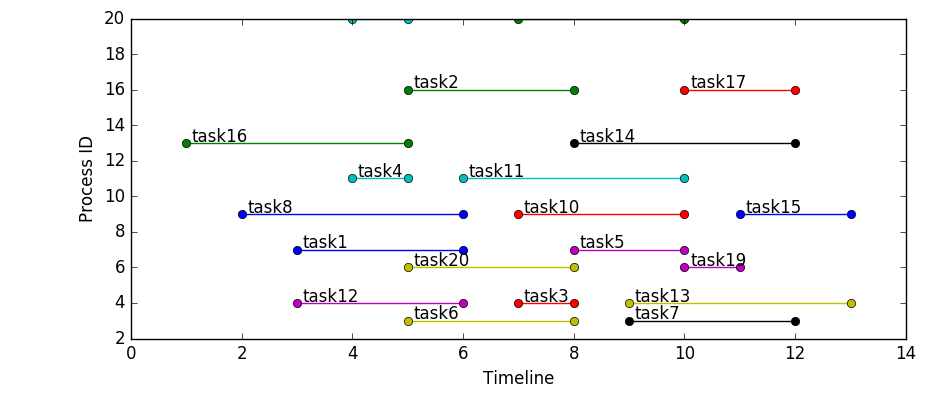

In [9]:
# plot them
using PyPlot

fig = figure(figsize=(10,4))
ax = fig[:add_subplot](111)

ylabel("Process ID")
xlabel("Timeline")

num_tasks = length(A2_y)
procIDs = zeros(num_tasks)
for i=1:num_tasks
    for k=1:num_tasks
        if A2_x[i,k]==1
            procIDs[i] = k
        end
    end
end

for i=1:num_tasks # annotate each Task with task ID
    procID = procIDs[i]
    ax[:annotate](string("task", string(i)), (start_time[i]+0.1, procID+0.1), textcoords="data")
end

for i=1:num_tasks
     # plot line segment between start and end time of each task
    procID = procIDs[i]
    plot([start_time[i], end_time[i]], [procID, procID], marker="o", linestyle="-")
end
;

In [10]:
# 2.B.part(1): Minimize the time to complete all tasks when no constraint on the start and end time of tasks
num_proc = 5 # the number of processors available
(B1_x, B1_z) = minTime(workload, num_proc)
println("All tasks are completed by ", B1_z)

All tasks are completed by 11.0


In [11]:
# 2.B.part(2): Bin Packing -- minimum number of processors needed to complete all tasks before given deadline T
T = 10 # the deadline (bin size)
(B2_x, B2_y, B2_obj) = minResource(workload, T)
println("Minimum number of processors needed: ", B2_obj)
for j=1:length(end_time)
    if B2_y[j]==0
        continue
    end
    print("Tasks scheduled on processor ", j, ": ")
    for i=1:length(end_time)
        if B2_x[i,j]==1
            print(i, "  ")
        end
    end
    println()
end

Minimum number of processors needed: 6.0
Tasks scheduled on processor 1: 3  10  12  18  19  
Tasks scheduled on processor 2: 6  7  20  
Tasks scheduled on processor 3: 1  2  16  
Tasks scheduled on processor 4: 13  15  17  
Tasks scheduled on processor 5: 5  8  11  
Tasks scheduled on processor 6: 4  9  14  


### 4.C. Results and Discussion for Model in 2.C 

In [12]:
# Data for 2.C
# This is a manuall created small dataset
# four levels: 1-(2,3,4,5)-(6,7,8)-(9,10)
# The execution time increases very fast since the number of variables and constraints is O(n^2 * m)
workload = [2 3 4 5 3 2 2 2 3 4]
precedence = Dict(1=>[], 2=>[1], 3=>[1], 4=>[1], 5=>[1], 6=>[2 3], 7=>[2 4], 8=>[4 5], 9=>[6 8], 10=>[7 8])
println("Total workload:", sum(workload))
;

Total workload:30


In [13]:
# Given m processors, find the earliest completion time
num_proc = 3
# lower bound and epsilon, based on analysis of the data
M = sum(workload) # this is an upper bound suitable for all we need 
(C_x, C_y, C_z) = minTimeWithTaskDependence(workload, num_proc, precedence, M)
println("All tasks are completed by: ", C_z)
;

All tasks are completed by: 13.999999999999995


In [14]:
# Let's show the task dependence and scheduling
xdata = C_y # xdata is the scheduled time for each task
ydata = zeros(length(xdata))
for j=1:num_proc
    tids = Int[]
    for i=1:length(workload)
        if C_x[i,j] == 1
            ydata[i] = j # ydata is the assigned processor
        end
    end
end

using PyPlot

fig = figure(figsize=(10,4))
ax = fig[:add_subplot](111)

ylim(0, num_proc+1)
xlim(0, C_z+1)
ylabel("Process ID")
xlabel("Timeline")
yticks(1:num_proc)

for i=1:length(xdata) # annotate each point with task ID, workload
    ax[:annotate](string("t", string(i), ", w=", workload[i]), (xdata[i], ydata[i]+0.1), textcoords="data")
end

for i=1:length(xdata)
    for k in precedence[i] # plot lines for the precedence
        plot([xdata[k], xdata[i]], [ydata[k], ydata[i]], marker="o", linestyle="-")
    end
end
;

From above figure, we can see that task 1-4-7-10 is the "path" completed by time 14 (which is the optimal objective value). However, task 4 is completed at time 7 but task 7 starts at time 8. The reason is that task 7 also depends on task 2, which is completed at time 8. 

In [15]:
# Let's vary the number of processors
num_tasks = length(workload)
num_procs = [i for i=1:num_tasks]
min_time = zeros(num_tasks)

M = sum(workload)
for i in num_procs
    (C_x, C_y, C_z) = minTimeWithTaskDependence(workload, i, precedence, M)
    min_time[i] = C_z
end
;

In [16]:
using PyPlot

fig = figure(figsize=(10,4))
ylabel("Earliest Completion Time")
xlabel("Number of Processors")

plot(num_procs, min_time, "ro-")
;

From above figure, the first observation is that when given only one processor, the earliest completion time is 30, which is also the total workload of all tasks. When we are given more processors, we can finish all tasks in shorter time. But the earliest completion time doesn't reduce any further after 4 processors, which is because the maximum parallelism needed is 4 (Task 2,3,4 and 5) in our small dataset.   

### 4.D. Results and Discussion for Model in 2.D 

In [17]:
# the n*(n+1) distance matrix, borrowed from the distance matrix betweeen 10 major airports in the US
# we add one more column, which is same as first column
A = [     0   587  1212   701  1936   604   748  2139  2182   543   0
        587     0   920   940  1745  1188   713  1858  1737   597   587
        1212   920     0   879   831  1726  1631   949  1021  1494  1212
        701   940   879     0  1379   968  1420  1645  1891  1220   701
        1936  1745   831  1379     0  2339  2451   347   959  2300  1936 
        604  1188  1726   968  2339     0  1092  2594  2734   923   604
        748   713  1631  1420  2451  1092     0  2571  2408   205   748
        2139  1858   949  1645   347  2594  2571     0   678  2442  2139
        2182  1737  1021  1891   959  2734  2408   678     0  2329  2182
        543   597  1494  1220  2300   923   205  2442  2329     0   543 ]

upper = 10 # the upper bound for some constraint in the model
ϵ = 1 # the positive number that is small enough
lower = -sum(A) # the lower bound needed for some constraint in the model

v = 1 # the travelling speed
# original tour is cities 1-6-4-5-8-9-3-2-7-10-1

# set time constraints
# For this dataset, 200000 is equivalent to no time constraint on that node
# below one ensures node 7 and 9 needs to be visited first
#times = [0 200000 200000 200000 200000 200000 888 200000 5555 200000]

# below one ensures the tour is cities 1-10-7-2-4-6-3-8-9-5-1
times = [0 1500 7000 2500 8000 4000 800 7000 8000 600]

(D_u,D_y) = TSPwithTimeConstraint(A, times, v, upper, ϵ, lower)
println("Positions of each city in the tour:", [Int(x) for x in round(D_u)])
println("Distance to each city:", round(D_y))

Positions of each city in the tour:[1,4,7,5,10,6,3,9,8,2,11]
Distance to each city:[0.0,1461.0,5301.0,2401.0,8000.0,3369.0,748.0,7000.0,6322.0,543.0,9936.0]


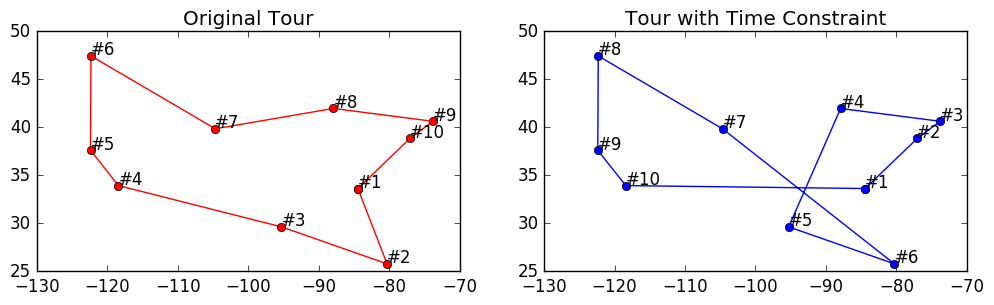

In [18]:
# let's plot and compare original tour and new tour due to time constraint
function getTour(positions)
    num_cities = length(positions)-1
    tour = zeros(Int, num_cities+1)
    for i=1:num_cities
        for k=1:num_cities
            if positions[k] == i
                tour[i] = k
            end
        end
    end
    
    tour[num_cities+1] = 1 # start and end at node 1
    
    return tour
end

# coordinates of each city
data = [ 33.636700  -84.427863 
         41.977320  -87.908005
         39.861667 -104.673166
         29.645417  -95.278888
         33.942437 -118.408121
         25.795361  -80.290110
         40.639926  -73.778694
         37.618806 -122.375416
         47.449889 -122.311777
         38.851444  -77.037721 ]

# plot original tour and the tour with time constraint
original_tour = [1 6 4 5 8 9 3 2 7 10 1]
tour = getTour([Int(round(k)) for k in D_u])

using PyPlot

fig = figure(figsize=(12,3))

axis("equal")
ox = [ data[i,2] for i in original_tour ]
oy = [ data[i,1] for i in original_tour ]

nx = [ data[i,2] for i in tour ]
ny = [ data[i,1] for i in tour ]

ax1 = subplot(1,2,1)
title("Original Tour")
for i=1:length(original_tour)-1 # positions in the tour
    ax1[:annotate](string("#", i), (ox[i], oy[i]+0.1), textcoords="data")
end
plot(ox, oy, "ro-")

ax2 = subplot(1,2,2)
title("Tour with Time Constraint")
for i=1:length(tour)-1 # positions in the tour
    ax2[:annotate](string("#", i), (nx[i], ny[i]+0.1), textcoords="data")
end
plot(nx, ny, "bo-")
;

Due to time constraint, now the optimal tour has length 9936 while the length of original TSP tour is only 7378.

For this problem, we have made several assumptions, such as travelling speed is constant, and there is no extra time spent at each location. Such assumptions may not hold in reality. A better solution should give a tour with sub-optimal total length but can tolerate unexpected conditions (For example, we might need to consider traffic jam between some pair of cities).  

## 5. Conclusion ##

In our project, we study how to use optimization for task scheduling. We model and solve a few problems with different settings, using what we have learnt from this course. What surprise us is that sometimes it can take a lot efforts to model a simple logic statement using linear constraints (e.g. those in 2.C and 2.D).

When modeling the TSP variant with time constraint, we make a few assumptions to simplify the model, but those assumptions may be unrealistic. Meanwhile, some modelled problems may have more constraints to consider in real scenario. For example, when scheduling courses to class rooms, the university may also need to consider room capacity, location; when delivering orders, the store may have multiple delivery vans, which makes the problem a **Multiple-Travelling-Salesmen-Single-Spot** problem. How to model these problems with additional constraints will be our future work.

## Appendix ##

<font color="red">**P1.**</font> Linear constraints for the logic statement (in 2.D):

$$ \text{for each pair of nodes } i,k, \text{ if } u_k=u_i+1, \text{ then } y_k = y_i + A_{ik}$$ 

First, let's introduce a binary variable $x_{ik}$ such that if $u_k=u_i+1$, then $x_{ik}=1$; if $x_{ik}=1$, then $y_k = y_i + A_{ik}$. How should we represent these two if-then statements with equality?

(1) The first if-then statement is tricky. It is equivalent to: if $u_k \geq u_i+1$ and $u_k \leq u_i+1$, then $x_{ik}=1$. It is a logic statement in the form of $P_1 \land P_2 \Rightarrow P_3$, where $P_1$ is $u_k \geq u_i+1$, $P_2$ is $u_k \leq u_i+1$, and $P_3$ is $x_{ik}=1$. Let's introduce two more binary variables:
  1. Binary variable $v_{ik}$ --- if $v_{ik}=1$, then $u_k \geq u_i+1$;
  1. Binary variable $r_{ik}$ --- if $r_{ik}=1$, then $u_k \leq u_i+1$.

Then $P_1 \land P_2 \Rightarrow P_3$ can be represented as: $v_{ik} + r_{ik} \leq 1 + x_{ik}$.

(2) The second if-then statement is equivalent to the combination of these two: if $x_{ik}=1$, then $y_k \geq y_i + A_{ik}$, and if $x_{ik}=1$, then $y_k \leq y_i + A_{ik}$.

<font color="red">**P2.**</font> We also modeled a few other problems for the case $m=1$, which can be viewed at <font color="blue">[**here**](http://pages.cs.wisc.edu/~hzhang0418/courses/CS524/extra.pdf)</font>